            new_cases  new_cases_smoothed
Date                                     
2020-07-01        223             125.000
2020-07-02        217             142.857
2020-07-03        130             146.143
2020-07-04        276             172.429
2020-07-05        207             186.000


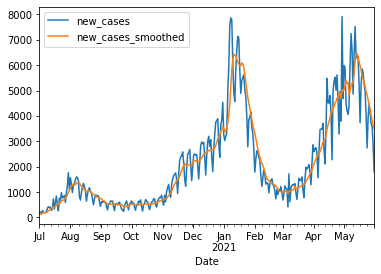

In [15]:
#read csv
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

def parser(x):
	return datetime.strptime('202'+x, '%Y-%m-%d')
 
series = read_csv('https://raw.githubusercontent.com/ll-cooool-j/DS-Assignment/main/Datasets/Datasets%20for%20ARIMA%20(Only%20Date%20%2B%20Confirmed)/Japan%20(Date%20%2B%20New%20Cases%20%2B%20Smoothed%20New%20Cases).csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

#we only use the raw data so we drop the smoothed data attribute out
series = series.drop(columns =['new_cases_smoothed'])

Observations: 115
Training Observations: 60
Testing Observations: 55
Observations: 170
Training Observations: 115
Testing Observations: 55
Observations: 225
Training Observations: 170
Testing Observations: 55
Observations: 280
Training Observations: 225
Testing Observations: 55
Observations: 335
Training Observations: 280
Testing Observations: 55


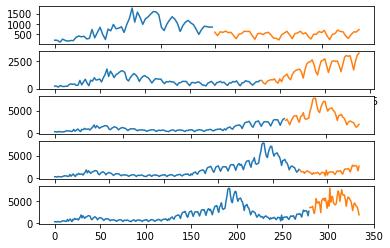

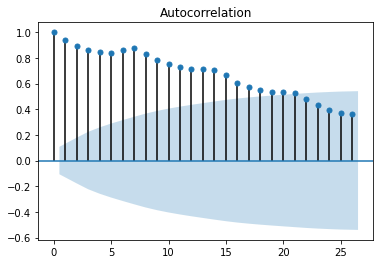

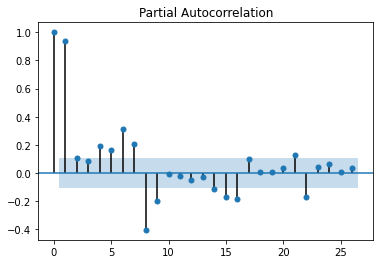

In [16]:
#Implementation of rolling-forward validation train-test split
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
X = series.values
splits = TimeSeriesSplit(n_splits=5)
pyplot.figure(1)
index = 1
for train_index, test_index in splits.split(X):
	train = X[train_index]
	test = X[test_index]
	print('Observations: %d' % (len(train) + len(test)))
	print('Training Observations: %d' % (len(train)))
	print('Testing Observations: %d' % (len(test)))
	pyplot.subplot(510 + index)
	pyplot.plot(train)
	pyplot.plot([None for i in train] + [x for x in test])
	index += 1
pyplot.show()

#Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series)
pyplot.show()
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series)
pyplot.show()

In [17]:
#split dataset into two subsets and calculate the mean
X = series.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
print('mean1=%f, mean2=%f' % (mean1, mean2))

mean1=988.910714, mean2=3367.880240


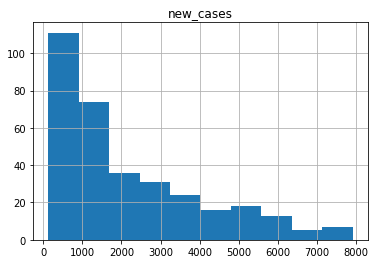

In [18]:
#check distribution of raw data set
series.hist()
pyplot.show()

In [19]:
#define function for ADF test (check stationarity)
import pandas as pd
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(series['new_cases'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.761087
p-value                          0.064051
#Lags Used                      16.000000
Number of Observations Used    318.000000
Critical Value (1%)             -3.451082
Critical Value (5%)             -2.870672
Critical Value (10%)            -2.571636
dtype: float64


[0.07206904]


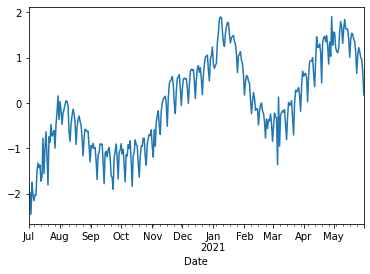

In [20]:
#Power transformation to achieve stationarity as far as possible
import numpy as np
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
pt.fit(series)
print(pt.lambdas_)
series['y'] = pt.transform(series)
series['y'].plot()

In [21]:
#make sure to drop NaN or inf values
series = series.drop(columns = ['new_cases'])
series.dropna(inplace=True)
print(series.head())
print(series.info())

                   y
Date                
2020-07-01 -1.952142
2020-07-02 -1.977887
2020-07-03 -2.451594
2020-07-04 -1.749019
2020-07-05 -2.022294
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 335 entries, 2020-07-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       335 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB
None


In [22]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:60], X[60:115] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=0.370
ARIMA(0, 0, 1) RMSE=0.302
ARIMA(0, 0, 2) RMSE=0.291
ARIMA(0, 0, 3) RMSE=0.286
ARIMA(0, 1, 0) RMSE=0.324
ARIMA(0, 1, 1) RMSE=0.326
ARIMA(0, 1, 2) RMSE=0.304
ARIMA(0, 1, 3) RMSE=0.306
ARIMA(0, 2, 0) RMSE=0.481
ARIMA(0, 2, 1) RMSE=0.331
ARIMA(1, 0, 0) RMSE=0.301
ARIMA(1, 0, 1) RMSE=0.317
ARIMA(1, 0, 2) RMSE=0.295
ARIMA(1, 1, 0) RMSE=0.328
ARIMA(1, 1, 1) RMSE=0.307
ARIMA(1, 1, 2) RMSE=0.307
ARIMA(1, 1, 3) RMSE=0.300
ARIMA(1, 2, 0) RMSE=0.426
ARIMA(2, 0, 0) RMSE=0.308
ARIMA(2, 0, 1) RMSE=0.294
ARIMA(2, 0, 2) RMSE=0.296
ARIMA(2, 1, 0) RMSE=0.327
ARIMA(2, 1, 1) RMSE=0.303
ARIMA(2, 1, 2) RMSE=0.314
ARIMA(2, 1, 3) RMSE=0.318
ARIMA(2, 2, 0) RMSE=0.411
Best ARIMA(0, 0, 3) RMSE=0.286


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -67.800
Method:                       css-mle   S.D. of innovations              0.296
Date:                Sat, 17 Jul 2021   AIC                            149.601
Time:                        02:10:59   BIC                            176.279
Sample:                    07-02-2020   HQIC                           160.238
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.007      1.130      0.259      -0.006       0.022
ar.L1.D.y     -0.4991      0.057     -8.691      0.000      -0.612      -0.387
ar.L2.D.y     -0.8611      0.052    -16.695      0.0

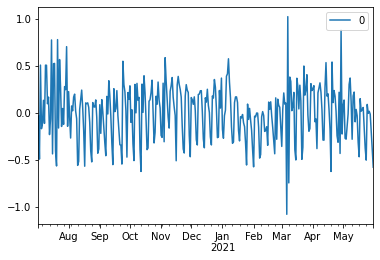

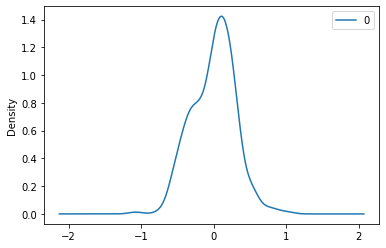

                0
count  334.000000
mean    -0.000434
std      0.297041
min     -1.077751
25%     -0.206857
50%      0.032837
75%      0.198601
max      1.021123
predicted=-0.586068, expected=-0.972816
predicted=-0.677180, expected=-1.297767
predicted=-1.069559, expected=-0.936405
predicted=-0.851277, expected=-0.988066
predicted=-0.996233, expected=-0.885504
predicted=-0.823664, expected=-1.001801
predicted=-0.970560, expected=-0.979567
predicted=-0.938946, expected=-1.268661
predicted=-1.053386, expected=-1.684927
predicted=-1.517030, expected=-1.143657
predicted=-1.190794, expected=-1.088043
predicted=-1.129078, expected=-0.896440
predicted=-0.882305, expected=-0.912253
predicted=-0.965047, expected=-0.902738
predicted=-0.939069, expected=-1.293237
predicted=-1.281065, expected=-1.777234
predicted=-1.414401, expected=-1.103103
predicted=-1.058186, expected=-1.067670
predicted=-0.872150, expected=-1.183740
predicted=-1.024238, expected=-1.028029
predicted=-1.157522, expected=-0.97956

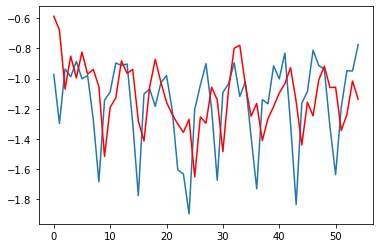

In [27]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(2,1,3))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (60 training observations and 55 testing observations)
train, test = X[:60], X[60:115] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [23]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:115], X[115:170] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=1.016
ARIMA(0, 0, 1) RMSE=0.621
ARIMA(0, 0, 2) RMSE=0.492
ARIMA(0, 0, 3) RMSE=0.439
ARIMA(0, 1, 0) RMSE=0.286
ARIMA(0, 1, 1) RMSE=0.293
ARIMA(0, 1, 2) RMSE=0.263
ARIMA(0, 1, 3) RMSE=0.263
ARIMA(0, 2, 0) RMSE=0.407
ARIMA(0, 2, 1) RMSE=0.290
ARIMA(1, 0, 0) RMSE=0.311
ARIMA(1, 0, 1) RMSE=0.313
ARIMA(1, 0, 2) RMSE=0.280
ARIMA(1, 0, 3) RMSE=0.281
ARIMA(1, 1, 0) RMSE=0.292
ARIMA(1, 1, 1) RMSE=0.269
ARIMA(1, 1, 2) RMSE=0.263
ARIMA(1, 1, 3) RMSE=0.252
ARIMA(1, 2, 0) RMSE=0.384
ARIMA(2, 0, 0) RMSE=0.311
ARIMA(2, 0, 1) RMSE=0.286
ARIMA(2, 0, 2) RMSE=0.280
ARIMA(2, 0, 3) RMSE=0.265
ARIMA(2, 1, 0) RMSE=0.284
ARIMA(2, 1, 1) RMSE=0.258
ARIMA(2, 1, 2) RMSE=0.238
ARIMA(2, 1, 3) RMSE=0.242
ARIMA(2, 2, 0) RMSE=0.362
Best ARIMA(2, 1, 2) RMSE=0.238


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -67.800
Method:                       css-mle   S.D. of innovations              0.296
Date:                Sat, 17 Jul 2021   AIC                            149.601
Time:                        02:12:35   BIC                            176.279
Sample:                    07-02-2020   HQIC                           160.238
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.007      1.130      0.259      -0.006       0.022
ar.L1.D.y     -0.4991      0.057     -8.691      0.000      -0.612      -0.387
ar.L2.D.y     -0.8611      0.052    -16.695      0.0

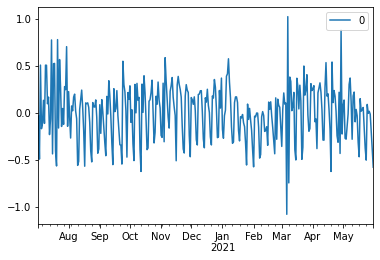

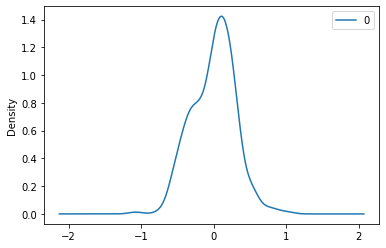

                0
count  334.000000
mean    -0.000434
std      0.297041
min     -1.077751
25%     -0.206857
50%      0.032837
75%      0.198601
max      1.021123
predicted=-0.846440, expected=-0.778872
predicted=-0.885323, expected=-1.173580
predicted=-1.086956, expected=-1.368110
predicted=-1.031446, expected=-0.910661
predicted=-1.010363, expected=-0.778872
predicted=-0.617370, expected=-0.689356
predicted=-0.631143, expected=-0.717068
predicted=-0.817918, expected=-0.589638
predicted=-0.642871, expected=-0.954460
predicted=-1.036666, expected=-1.189883
predicted=-1.015036, expected=-0.588446
predicted=-0.625909, expected=-0.949507
predicted=-0.992551, expected=-0.414268
predicted=-0.566930, expected=-0.283062
predicted=-0.511407, expected=-0.169406
predicted=-0.533007, expected=-0.500224
predicted=-0.260298, expected=-0.689356
predicted=-0.565282, expected=-0.175205
predicted=-0.432931, expected=0.000261
predicted=0.093373, expected=0.083039
predicted=-0.088992, expected=0.122991
pr

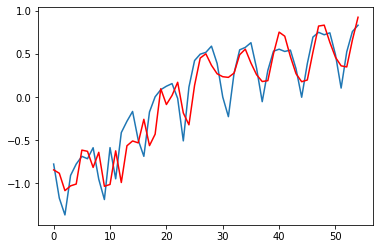

In [28]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(2,1,3))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (115 training observations and 55 testing observations)
train, test = X[:115], X[115:170] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [24]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:170], X[170:225] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.531
ARIMA(0, 0, 1) RMSE=0.843
ARIMA(0, 0, 2) RMSE=0.607
ARIMA(0, 1, 0) RMSE=0.234
ARIMA(0, 1, 1) RMSE=0.264
ARIMA(0, 1, 2) RMSE=0.252
ARIMA(0, 1, 3) RMSE=0.249
ARIMA(0, 2, 0) RMSE=0.301
ARIMA(0, 2, 1) RMSE=0.235
ARIMA(1, 0, 0) RMSE=0.245
ARIMA(1, 0, 1) RMSE=0.253
ARIMA(1, 0, 2) RMSE=0.244
ARIMA(1, 0, 3) RMSE=0.241
ARIMA(1, 1, 0) RMSE=0.241
ARIMA(1, 1, 1) RMSE=0.253
ARIMA(1, 1, 2) RMSE=0.250
ARIMA(1, 1, 3) RMSE=0.264
ARIMA(1, 2, 0) RMSE=0.289
ARIMA(2, 0, 0) RMSE=0.247
ARIMA(2, 0, 1) RMSE=0.245
ARIMA(2, 0, 2) RMSE=0.242
ARIMA(2, 0, 3) RMSE=0.240
ARIMA(2, 1, 0) RMSE=0.244
ARIMA(2, 1, 1) RMSE=0.249
ARIMA(2, 1, 2) RMSE=0.251
ARIMA(2, 1, 3) RMSE=0.214
ARIMA(2, 2, 0) RMSE=0.291
Best ARIMA(2, 1, 3) RMSE=0.214


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -67.800
Method:                       css-mle   S.D. of innovations              0.296
Date:                Sat, 17 Jul 2021   AIC                            149.601
Time:                        02:13:25   BIC                            176.279
Sample:                    07-02-2020   HQIC                           160.238
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.007      1.130      0.259      -0.006       0.022
ar.L1.D.y     -0.4991      0.057     -8.691      0.000      -0.612      -0.387
ar.L2.D.y     -0.8611      0.052    -16.695      0.0

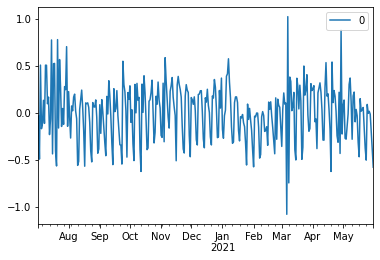

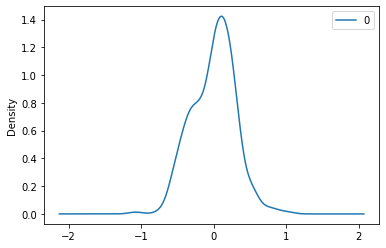

                0
count  334.000000
mean    -0.000434
std      0.297041
min     -1.077751
25%     -0.206857
50%      0.032837
75%      0.198601
max      1.021123
predicted=0.921874, expected=0.678823
predicted=0.677308, expected=0.779751
predicted=0.508624, expected=0.528641
predicted=0.411771, expected=0.185094
predicted=0.404724, expected=0.618474
predicted=0.717340, expected=0.856984
predicted=0.985181, expected=1.017388
predicted=1.034803, expected=1.030915
predicted=0.890482, expected=1.056941
predicted=0.752458, expected=0.735180
predicted=0.645292, expected=0.490860
predicted=0.675856, expected=0.975587
predicted=1.023948, expected=1.046112
predicted=1.238037, expected=1.237468
predicted=1.268172, expected=0.850641
predicted=0.969979, expected=0.767342
predicted=0.711455, expected=0.828898
predicted=0.680408, expected=0.876861
predicted=0.831804, expected=1.338745
predicted=1.201017, expected=1.559416
predicted=1.498063, expected=1.850265
predicted=1.681692, expected=1.897908
pr

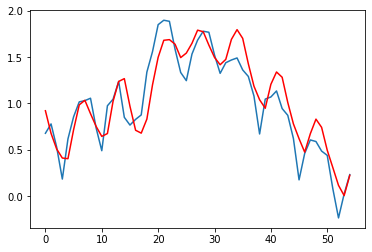

In [29]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(2,1,3))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (170 training observations and 55 testing observations)
train, test = X[0:170], X[170:225] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [25]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:225], X[225:280] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.438
ARIMA(0, 0, 1) RMSE=0.566
ARIMA(0, 0, 2) RMSE=0.445
ARIMA(0, 1, 0) RMSE=0.400
ARIMA(0, 1, 1) RMSE=0.353
ARIMA(0, 1, 2) RMSE=0.360
ARIMA(0, 1, 3) RMSE=0.360
ARIMA(0, 2, 0) RMSE=0.685
ARIMA(0, 2, 1) RMSE=0.402
ARIMA(1, 0, 0) RMSE=0.391
ARIMA(1, 0, 1) RMSE=0.357
ARIMA(1, 0, 2) RMSE=0.360
ARIMA(1, 0, 3) RMSE=0.359
ARIMA(1, 1, 0) RMSE=0.375
ARIMA(1, 1, 1) RMSE=0.350
ARIMA(1, 1, 2) RMSE=0.360
ARIMA(1, 1, 3) RMSE=0.360
ARIMA(1, 2, 0) RMSE=0.517
ARIMA(2, 0, 0) RMSE=0.372
ARIMA(2, 0, 1) RMSE=0.350
ARIMA(2, 0, 2) RMSE=0.360
ARIMA(2, 0, 3) RMSE=0.359
ARIMA(2, 1, 0) RMSE=0.380
ARIMA(2, 1, 1) RMSE=0.363
ARIMA(2, 1, 2) RMSE=0.347
ARIMA(2, 1, 3) RMSE=0.313
ARIMA(2, 2, 0) RMSE=0.490
Best ARIMA(2, 1, 3) RMSE=0.313


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -67.800
Method:                       css-mle   S.D. of innovations              0.296
Date:                Sat, 17 Jul 2021   AIC                            149.601
Time:                        02:16:39   BIC                            176.279
Sample:                    07-02-2020   HQIC                           160.238
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.007      1.130      0.259      -0.006       0.022
ar.L1.D.y     -0.4991      0.057     -8.691      0.000      -0.612      -0.387
ar.L2.D.y     -0.8611      0.052    -16.695      0.0

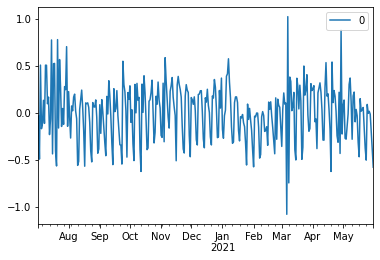

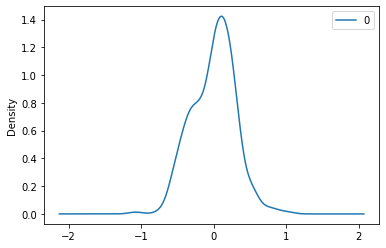

                0
count  334.000000
mean    -0.000434
std      0.297041
min     -1.077751
25%     -0.206857
50%      0.032837
75%      0.198601
max      1.021123
predicted=0.417806, expected=0.113940
predicted=0.276507, expected=-0.158712
predicted=-0.074438, expected=-0.121643
predicted=-0.243281, expected=-0.130401
predicted=-0.250663, expected=-0.480554
predicted=-0.301558, expected=-0.165281
predicted=-0.077338, expected=-0.045650
predicted=-0.083999, expected=0.000975
predicted=0.050250, expected=-0.174375
predicted=-0.171412, expected=-0.227877
predicted=-0.325834, expected=-0.414268
predicted=-0.348476, expected=-0.770431
predicted=-0.563445, expected=-0.347755
predicted=-0.197160, expected=-0.557882
predicted=-0.306922, expected=-0.366228
predicted=-0.330994, expected=-0.393002
predicted=-0.459633, expected=-0.240110
predicted=-0.224652, expected=-0.454846
predicted=-0.564180, expected=-0.841315
predicted=-0.629987, expected=-0.537195
predicted=-0.429989, expected=-0.219218
pre

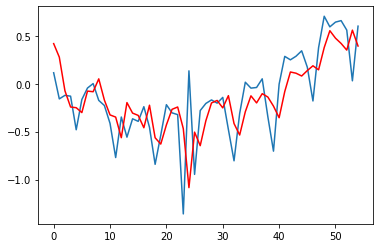

In [30]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame

# fit model
series = series.astype('float64')
model = ARIMA(series, order=(2,1,3))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (225 training observations and 55 testing observations)
train, test = X[:225], X[225:280] 
history = [x for x in train]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


In [26]:
# grid search ARIMA parameters for the whole dataset (with 280 training observations and 55 testing observations)
import warnings
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  X = X.astype('float64')
  # prepare training dataset
  train, test = X[:280], X[280:] 
  history = [x for x in train]

  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 # load dataset
idx = pd.date_range("2020-07-01", periods=335)
series.index = idx.to_period()
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1.392
ARIMA(0, 0, 1) RMSE=0.834
ARIMA(0, 0, 2) RMSE=0.596
ARIMA(0, 0, 3) RMSE=0.559
ARIMA(0, 1, 0) RMSE=0.331
ARIMA(0, 1, 1) RMSE=0.319
ARIMA(0, 1, 2) RMSE=0.308
ARIMA(0, 1, 3) RMSE=0.308
ARIMA(0, 2, 0) RMSE=0.515
ARIMA(0, 2, 1) RMSE=0.332
ARIMA(1, 0, 0) RMSE=0.332
ARIMA(1, 0, 1) RMSE=0.321
ARIMA(1, 0, 2) RMSE=0.309
ARIMA(1, 0, 3) RMSE=0.309
ARIMA(1, 1, 0) RMSE=0.325
ARIMA(1, 1, 1) RMSE=0.309
ARIMA(1, 1, 2) RMSE=0.308
ARIMA(1, 1, 3) RMSE=0.307
ARIMA(1, 2, 0) RMSE=0.432
ARIMA(2, 0, 0) RMSE=0.326
ARIMA(2, 0, 1) RMSE=0.310
ARIMA(2, 0, 2) RMSE=0.309
ARIMA(2, 0, 3) RMSE=0.308
ARIMA(2, 1, 0) RMSE=0.320
ARIMA(2, 1, 1) RMSE=0.307
ARIMA(2, 1, 2) RMSE=0.288
ARIMA(2, 1, 3) RMSE=0.286
ARIMA(2, 2, 0) RMSE=0.402
Best ARIMA(2, 1, 3) RMSE=0.286


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  334
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 -67.800
Method:                       css-mle   S.D. of innovations              0.296
Date:                Sat, 17 Jul 2021   AIC                            149.601
Time:                        02:19:28   BIC                            176.279
Sample:                    07-02-2020   HQIC                           160.238
                         - 05-31-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0080      0.007      1.130      0.259      -0.006       0.022
ar.L1.D.y     -0.4991      0.057     -8.691      0.000      -0.612      -0.387
ar.L2.D.y     -0.8611      0.052    -16.695      0.0

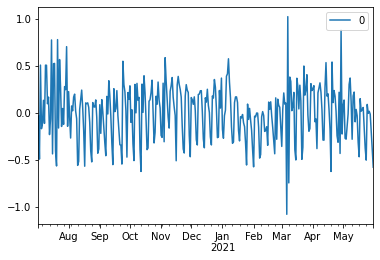

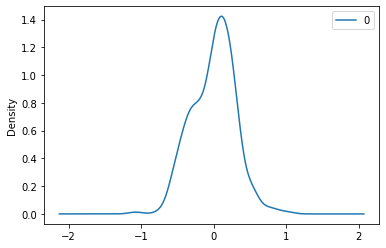

                0
count  334.000000
mean    -0.000434
std      0.297041
min     -1.077751
25%     -0.206857
50%      0.032837
75%      0.198601
max      1.021123
predicted=0.702042, expected=0.918031
predicted=0.935505, expected=0.930685
predicted=0.874698, expected=0.927035
predicted=0.709230, expected=0.999957
predicted=0.659953, expected=0.636263
predicted=0.614587, expected=0.360416
predicted=0.642702, expected=0.916692
predicted=0.992889, expected=1.461236
predicted=1.334939, expected=1.230961
predicted=1.238926, expected=1.229916
predicted=1.039952, expected=1.303738
predicted=0.978121, expected=1.120882
predicted=1.014481, expected=0.442531
predicted=0.915168, expected=1.345203
predicted=1.327437, expected=1.436367
predicted=1.518330, expected=1.470792
predicted=1.443297, expected=1.354949
predicted=1.212119, expected=1.491397
predicted=1.152921, expected=1.258838
predicted=1.171906, expected=0.859793
predicted=1.195990, expected=1.343532
predicted=1.484424, expected=1.027854
pr

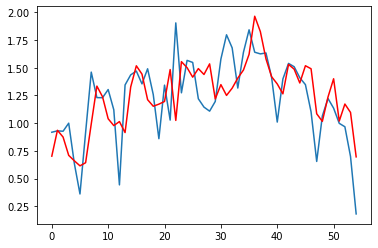

In [31]:
# fit an ARIMA model and plot residual errors
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
# fit model
series = series.astype('float64')
model = ARIMA(series, order=(2,1,3))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
import numpy as np
import itertools
from itertools import chain
X = series.values.astype('float64')

# prepare training dataset (280 training observations and 55 testing observations)
train, test = X[:280], X[280:] 
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(2,1,3))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
mae = mean_absolute_error(test, predictions)
print('MAE score: %.3f' % mae)
r2 = r2_score(test, predictions)
print('R2 score: %.3f' % r2)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()


                   y
2020-07-01 -1.952142
2020-07-02 -1.977887
2020-07-03 -2.451594
2020-07-04 -1.749019
2020-07-05 -2.022294
...              ...
2021-05-27  1.135600
2021-05-28  0.998389
2021-05-29  0.967572
2021-05-30  0.698963
2021-05-31  0.180194

[335 rows x 1 columns]


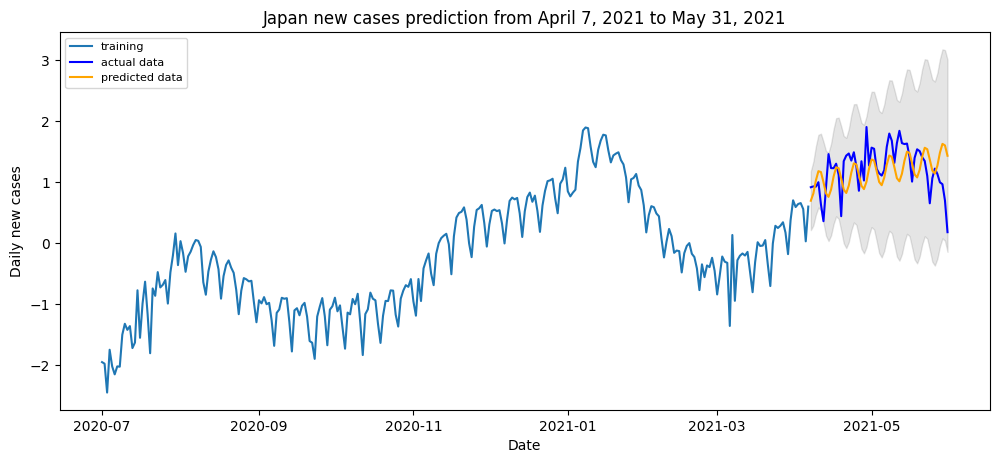

In [32]:
import pandas as pd
from statsmodels.tsa.stattools import acf 
import matplotlib.pyplot as plt
from scipy.special import inv_boxcox

print(series)
train1 = series.iloc[0:280]
idx1 = pd.date_range("2020-07-01", periods=280)
train1.index = idx1

test1 = series.iloc[280:]
idx2 = pd.date_range("2021-04-07", periods=55)
test1.index = idx2


# Forecast
fc, se, conf = model_fit.forecast(55, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test1.index)
lower_series = pd.Series(conf[:, 0], index=test1.index)
upper_series = pd.Series(conf[:, 1], index=test1.index)
fig = plt.figure(figsize=(12,5), dpi=100)
plt.plot(train1, label='training')
plt.plot(test1, color = 'blue', label='actual data')
plt.plot(fc_series, color = 'orange',label='predicted data')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Japan new cases prediction from April 7, 2021 to May 31, 2021')
plt.xlabel('Date')
plt.ylabel('Daily new cases')
plt.legend(loc='upper left', fontsize=8)
plt.show()
